In [3]:
import numpy as np
import astropy.units as u
import astropy.time
import fitsio
from astropy.io import fits
from astropy.table import Table
import matplotlib.pyplot as plt
import os
import pandas as pd
from matplotlib.collections import LineCollection
import matplotlib.patches as patches

In [5]:
hdul = fits.open('OBA_with_kinematics.fits')
hdul = hdul[1].data
t = Table(hdul)

In [41]:
Lc = 265.15
Bc = 1.45

In [17]:
vL = t['vLcorr']
vL_p = t['vLcorr_p']
vL_n = t['vLcorr_n']
vB = t['vBcorr']
vB_p = t['vBcorr_p']
vB_n = t['vBcorr_n']
l = t['l_1']
b = t['b_1']
teff = t['teff']
plx = t['plx']

In [18]:
o_mask = teff > 30000

In [21]:
radius = 0.5 
distance = 1000

r_deg = (radius / distance) * 57.2958

In [23]:
cluster_vL = -48.89
cluster_vB = -9.74

In [25]:
vL = vL - cluster_vL
vB = vB - cluster_vB

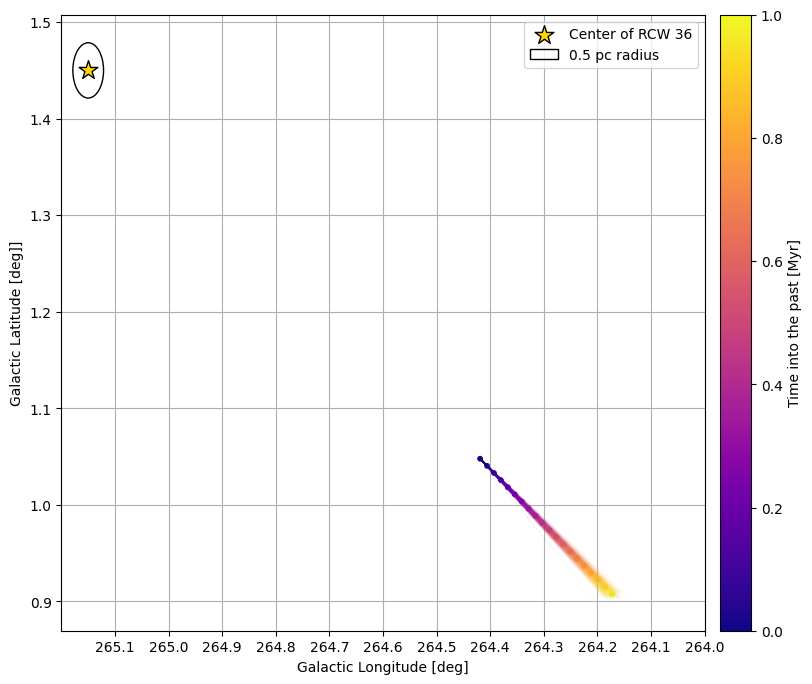

In [48]:
scale = 50
n_samples = 200
age_range = np.linspace(0, 1.0, 20)  
d_pc = (1 / plx[o_mask][0]) * 1000 

l0 = l[o_mask][0]
b0 = b[o_mask][0]

vL_med = vL[o_mask][0]
vB_med = vB[o_mask][0]

vL_p_star = vL_p[o_mask][0]
vL_n_star = vL_n[o_mask][0]
vB_p_star = vB_p[o_mask][0]
vB_n_star = vB_n[o_mask][0]

vL_med *= scale
vB_med *= scale
vL_p_star *= scale
vL_n_star *= scale
vB_p_star *= scale
vB_n_star *= scale


all_l = []
all_b = []

n = 0
while n < 1000:
    a_vL = np.random.normal(0, 1)
    vL_err = (a_vL > 0) * vL_p_star * a_vL + (a_vL <= 0) * vL_n_star * a_vL
    vL_sample = vL_med + vL_err

    a_vB = np.random.normal(0, 1)
    vB_err = (a_vB > 0) * vB_p_star * a_vB + (a_vB <= 0) * vB_n_star * a_vB
    vB_sample = vB_med + vB_err

    muL = vL_sample / (4.74 * d_pc)
    muB = vB_sample / (4.74 * d_pc)

    l_path = [l0 - muL * t for t in age_range]
    b_path = [b0 - muB * t for t in age_range]
    all_l.append(l_path)
    all_b.append(b_path)

    n += 1

fig, ax = plt.subplots(figsize=(10, 8))
cmap = cm.plasma
norm = plt.Normalize(age_range.min(), age_range.max())

for i in range(n_samples):
    l_path = np.array(all_l[i])
    b_path = np.array(all_b[i])
    
    points = np.array([l_path, b_path]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    
    lc = LineCollection(segments, cmap=cmap, norm=norm, alpha=0.05) 
    lc.set_array(age_range[:-1])
    lc.set_linewidth(1)
    ax.add_collection(lc)

muL_med = vL_med / (4.74 * d_pc)
muB_med = vB_med / (4.74 * d_pc)
l_med = [l0 - muL_med * t for t in age_range]
b_med = [b0 - muB_med * t for t in age_range]
sc = ax.scatter(l_med, b_med, c=age_range, cmap=cmap, s=10, zorder=1)

ax.scatter(Lc, Bc, marker='*', color='gold', edgecolor='black', s=200, label='Center of RCW 36', zorder=3)

circle = patches.Circle(xy=(Lc, Bc),
                radius=r_deg,
                edgecolor='black',
                facecolor='none',
                label=f'0.5 pc radius')

ax.add_patch(circle)

y_ticks = np.arange(0.9, 1.6, 0.1)
x_ticks = np.arange(264, 265.2, 0.1)

ax.set_yticks(y_ticks)
ax.set_xticks(x_ticks)
ax.set_xlim(265.2, 264)
ax.set_xlabel('Galactic Longitude [deg]')
ax.set_ylabel('Galactic Latitude [deg]]')
ax.legend()
ax.grid()

cb = plt.colorbar(sc, ax=ax, pad=0.02)
cb.set_label('Time into the past [Myr]')

plt.savefig('o_trajectory.png', bbox_inches='tight')
plt.show()

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


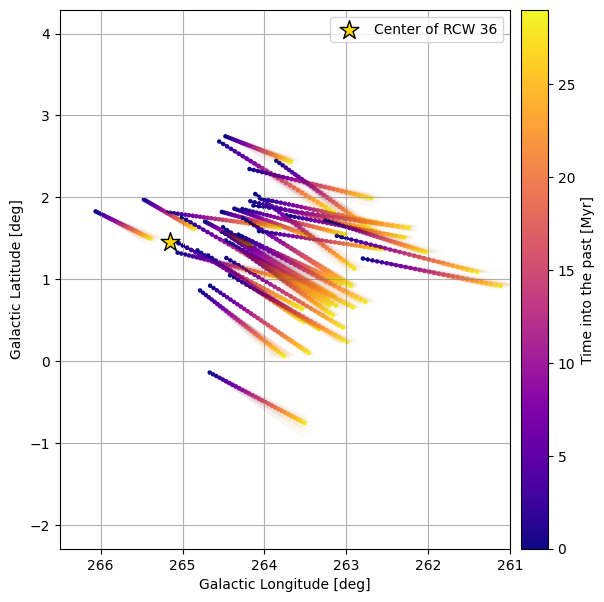

In [53]:
scale = 10
age_range = np.arange(0.0, 30.0, 1.0)
cmap = cm.plasma
norm = plt.Normalize(age_range.min(), age_range.max())
n_samples = 200  

b_mask = (teff < 30000) & (teff > 10000)
l0 = l[b_mask]
b0 = b[b_mask]
vL_med = vL[b_mask] * scale
vB_med = vB[b_mask] * scale
vL_p_star = vL_p[b_mask] * scale
vL_n_star = vL_n[b_mask] * scale
vB_p_star = vB_p[b_mask] * scale
vB_n_star = vB_n[b_mask] * scale

d_pc = (1 / plx[b_mask]) * 1000

fig, ax = plt.subplots(figsize=(7, 7))

for star_idx in range(len(l0)):
    for _ in range(n_samples):
        a_vL = np.random.normal(0, 1)
        vL_err = (a_vL > 0) * vL_p_star[star_idx] * a_vL + (a_vL <= 0) * vL_n_star[star_idx] * a_vL
        vL_sample = vL_med[star_idx] + vL_err

        a_vB = np.random.normal(0, 1)
        vB_err = (a_vB > 0) * vB_p_star[star_idx] * a_vB + (a_vB <= 0) * vB_n_star[star_idx] * a_vB
        vB_sample = vB_med[star_idx] + vB_err

        muL = vL_sample / (4.74 * d_pc[star_idx])
        muB = vB_sample / (4.74 * d_pc[star_idx])

        l_path = [l0[star_idx] - muL * t for t in age_range]
        b_path = [b0[star_idx] - muB * t for t in age_range]

        points = np.array([l_path, b_path]).T.reshape(-1, 1, 2)
        segments = np.concatenate([points[:-1], points[1:]], axis=1)

        lc = LineCollection(segments, cmap=cmap, norm=norm, alpha=0.01)
        lc.set_array(age_range[:-1])
        lc.set_linewidth(1)
        ax.add_collection(lc)

    muL_med = vL_med[star_idx] / (4.74 * d_pc[star_idx])
    muB_med = vB_med[star_idx] / (4.74 * d_pc[star_idx])
    l_med = [l0[star_idx] - muL_med * t for t in age_range]
    b_med = [b0[star_idx] - muB_med * t for t in age_range]
    sc = ax.scatter(l_med, b_med, c=age_range, cmap=cmap, s=5, zorder=1)

ax.scatter(Lc, Bc, marker='*', color='gold', edgecolor='black', s=200, label='Center of RCW 36', zorder=3)


ax.set_xlabel('Galactic Longitude [deg]')
ax.set_ylabel('Galactic Latitude [deg]')
ax.set_xlim(266.5, 261)
ax.set_ylim(-2, 4)

ax.set_yticks(np.arange(-2, 5, 1))
ax.legend()
ax.grid()
ax.set_aspect('equal', adjustable='datalim')

cb = plt.colorbar(sc, ax=ax, pad=0.02)
cb.set_label('Time into the past [Myr]')

plt.savefig('b_trajectories.png', bbox_inches='tight')
plt.show()